# Inference Explorer
Visualize LLM token predictions, logits, and probabilities step-by-step.

In [58]:
import mlx.core as mx
from mlx_lm import load
import matplotlib.pyplot as plt
import numpy as np

In [59]:
# Load model and tokenizer
print("Loading model...")
model, tokenizer = load("mlx-community/Qwen3-4B-4bit")
print("Model loaded!")

Loading model...


Fetching 9 files: 100%|██████████| 9/9 [00:00<00:00, 195589.31it/s]


Model loaded!


## Helper Functions

In [60]:
def get_first_token_logits(prompt: str):
    """Get logits for the first generated token."""
    tokens = mx.array(tokenizer.encode(prompt))
    logits = model(tokens[None])[0, -1, :]
    return logits

def get_top_k(logits: mx.array, k: int = 10):
    """Extract top-k tokens with their logits and probabilities."""
    probs = mx.softmax(logits)
    top_indices = mx.argsort(logits)[-k:][::-1].tolist()
    
    results = []
    for idx in top_indices:
        token_str = tokenizer.decode([idx])
        results.append({
            "token_id": idx,
            "token": token_str,
            "logit": logits[idx].item(),
            "prob": probs[idx].item()
        })
    return results

def sample_token(logits: mx.array, temperature: float = 0.0) -> int:
    """Sample token with temperature. temp=0 is greedy (argmax)."""
    if temperature == 0:
        return mx.argmax(logits).item()
    scaled = logits / temperature
    return mx.random.categorical(scaled).item()

def generate(tokens: mx.array, max_tokens: int = 50, temperature: float = 0.0):
    """Continue generation from token sequence with optional temperature."""
    prompt_len = len(tokens)
    
    for _ in range(max_tokens):
        logits = model(tokens[None])[0, -1, :]
        next_token = sample_token(logits, temperature)
        
        if next_token == tokenizer.eos_token_id:
            break
        tokens = mx.concatenate([tokens, mx.array([next_token])])
    
    return tokenizer.decode(tokens[prompt_len:].tolist())

# Keep old name for compatibility
generate_greedy = lambda tokens, max_tokens=50: generate(tokens, max_tokens, temperature=0.0)

## 1. Top-K Logits Bar Chart
Visualize the top token predictions for a given prompt.

In [70]:
# Set your prompt here


PROMPT = """ <|im_start|>user Tell me a joke<|im_end|>
  <|im_start|>assistant
  <think>

</think>


"""

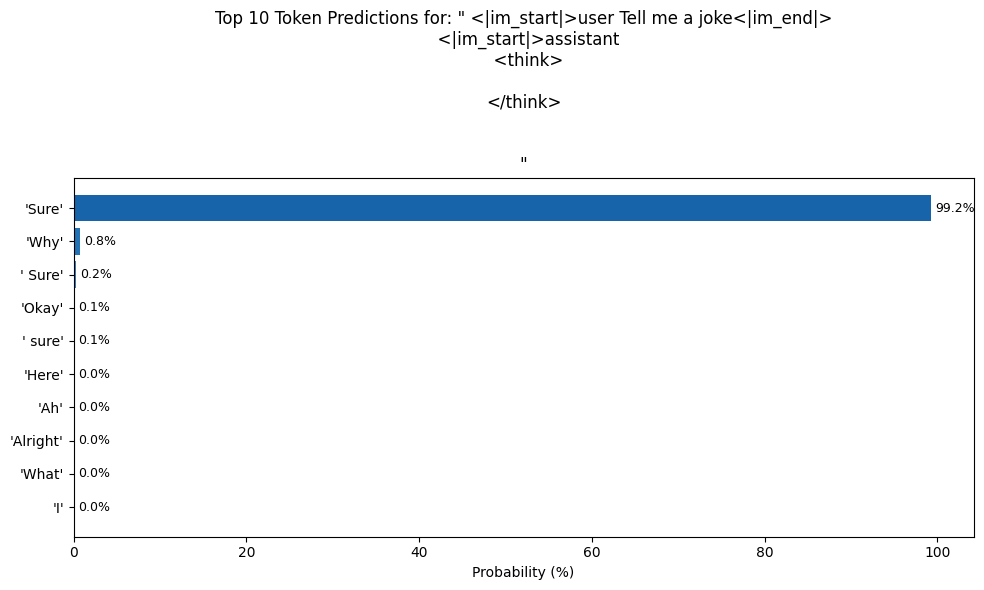


Rank   Token ID   Token           Logit      Prob      
-------------------------------------------------------
1      39814      'Sure'          32.5000    99.22     %
2      10234      'Why'           27.6250    0.76      %
3      22555      ' Sure'         26.5000    0.25      %
4      32313      'Okay'          25.0000    0.05      %
5      2704       ' sure'         25.0000    0.05      %
6      8420       'Here'          24.7500    0.04      %
7      24765      'Ah'            21.6250    0.00      %
8      71486      'Alright'       21.3750    0.00      %
9      3838       'What'          21.0000    0.00      %
10     40         'I'             20.6250    0.00      %


In [71]:
# Get top-10 predictions
logits = get_first_token_logits(PROMPT)
top_k = get_top_k(logits, k=10)

# Prepare data for plotting
tokens = [repr(t["token"]) for t in top_k]
probs = [t["prob"] * 100 for t in top_k]
colors = plt.cm.Blues(np.linspace(0.8, 0.3, len(tokens)))

# Create horizontal bar chart
fig, ax = plt.subplots(figsize=(10, 6))
bars = ax.barh(tokens[::-1], probs[::-1], color=colors[::-1])
ax.set_xlabel("Probability (%)")
ax.set_title(f"Top 10 Token Predictions for: \"{PROMPT}\"")

# Add probability labels
for bar, prob in zip(bars, probs[::-1]):
    ax.text(bar.get_width() + 0.5, bar.get_y() + bar.get_height()/2, 
            f"{prob:.1f}%", va="center", fontsize=9)

plt.tight_layout()
plt.show()

# Print table
print(f"\n{'Rank':<6} {'Token ID':<10} {'Token':<15} {'Logit':<10} {'Prob':<10}")
print("-" * 55)
for i, t in enumerate(top_k, 1):
    print(f"{i:<6} {t['token_id']:<10} {repr(t['token']):<15} {t['logit']:<10.4f} {t['prob']*100:<10.2f}%")

## 2. Cumulative Probability Distribution
See how probability mass is distributed across top tokens.

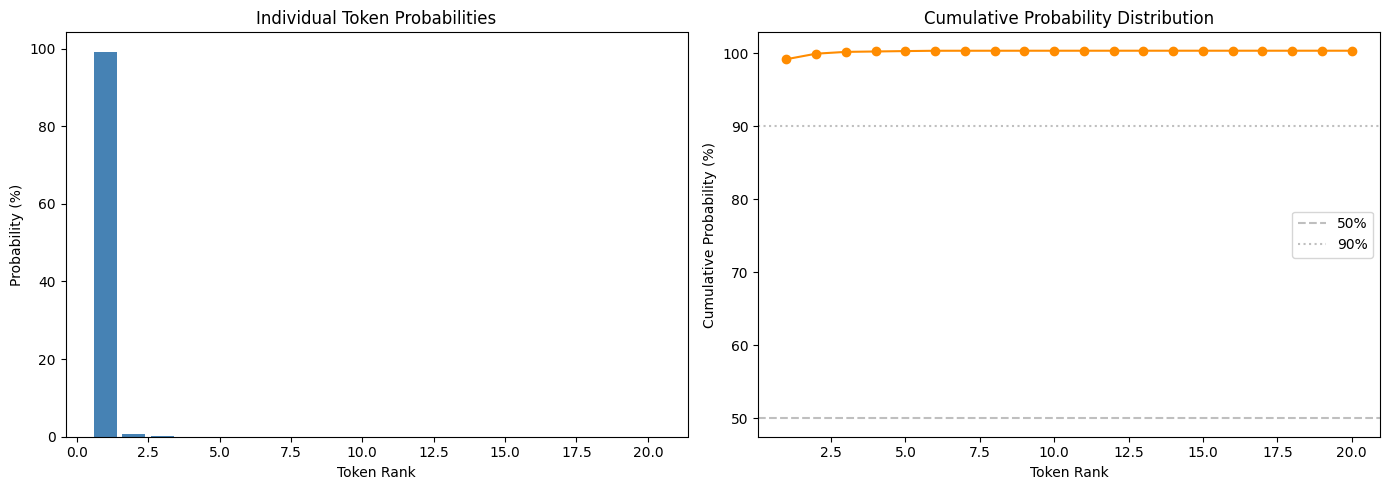

Top 3 tokens cover: 100.2% of probability
Top 10 tokens cover: 100.4% of probability
Top 20 tokens cover: 100.4% of probability


In [72]:
# Get top-20 for cumulative plot
top_20 = get_top_k(logits, k=20)
probs_20 = [t["prob"] * 100 for t in top_20]
cumulative = np.cumsum(probs_20)

fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(14, 5))

# Individual probabilities
ax1.bar(range(1, 21), probs_20, color="steelblue")
ax1.set_xlabel("Token Rank")
ax1.set_ylabel("Probability (%)")
ax1.set_title("Individual Token Probabilities")

# Cumulative probability
ax2.plot(range(1, 21), cumulative, marker="o", color="darkorange")
ax2.axhline(y=50, color="gray", linestyle="--", alpha=0.5, label="50%")
ax2.axhline(y=90, color="gray", linestyle=":", alpha=0.5, label="90%")
ax2.set_xlabel("Token Rank")
ax2.set_ylabel("Cumulative Probability (%)")
ax2.set_title("Cumulative Probability Distribution")
ax2.legend()

plt.tight_layout()
plt.show()

print(f"Top 3 tokens cover: {cumulative[2]:.1f}% of probability")
print(f"Top 10 tokens cover: {cumulative[9]:.1f}% of probability")
print(f"Top 20 tokens cover: {cumulative[19]:.1f}% of probability")

## 3. Branching Exploration
See how different first-token choices lead to different outputs.

In [79]:
def branch_generate(prompt: str, num_branches: int = 3, max_tokens: int = 40, temperature: float = 0.7):
    """Generate multiple branches from different first-token choices."""
    tokens = mx.array(tokenizer.encode(prompt))
    logits = get_first_token_logits(prompt)
    top_k = get_top_k(logits, k=num_branches)
    
    branches = []
    for t in top_k:
        branch_tokens = mx.concatenate([tokens, mx.array([t["token_id"]])])
        generated = generate(branch_tokens, max_tokens - 1, temperature)
        branches.append({
            **t,
            "full_text": t["token"] + generated
        })
    return branches

# Generate branches with temperature for variability
TEMPERATURE = 1.0  # Change this for more/less randomness (0=greedy, 1=full sampling)

branches = branch_generate(PROMPT, num_branches=3, max_tokens=50, temperature=TEMPERATURE)

# Display
print(f"Prompt: \"{PROMPT}\"")
print(f"Temperature: {TEMPERATURE}\n")
print("=" * 80)

for i, b in enumerate(branches, 1):
    print(f"\nBranch {i}: {repr(b['token'])} (prob: {b['prob']*100:.2f}%)")
    print("-" * 80)
    print(b["full_text"])
    print()

Prompt: " <|im_start|>user Tell me a joke<|im_end|>
  <|im_start|>assistant
  <think>

</think>


"
Temperature: 1.0


Branch 1: 'Sure' (prob: 99.22%)
--------------------------------------------------------------------------------
Sure! Here's a light-hearted joke for you:

Why don't scientists trust atoms?

Because they make up everything! 😄

Want another one?


Branch 2: 'Why' (prob: 0.76%)
--------------------------------------------------------------------------------
Why did the scarecrow win an award?  
Because he was outstanding in his field! 😄


Branch 3: ' Sure' (prob: 0.25%)
--------------------------------------------------------------------------------
 Sure! Here's a classic joke for you:

Why don't scientists trust atoms?

Because they make up everything! 🤡

Want another one? 😄



## 4. Step-by-Step Generation
Watch generation unfold token by token.

In [74]:
def step_by_step_generate(prompt: str, num_steps: int = 10, temperature: float = 0.0):
    """Generate tokens step by step, showing top predictions at each step."""
    tokens = mx.array(tokenizer.encode(prompt))
    prompt_len = len(tokens)
    steps = []
    
    for step in range(num_steps):
        logits = model(tokens[None])[0, -1, :]
        top_k = get_top_k(logits, k=5)
        
        generated_text = tokenizer.decode(tokens[prompt_len:].tolist())
        
        # Sample next token (with temperature)
        next_token = sample_token(logits, temperature)
        chosen_token = tokenizer.decode([next_token])
        chosen_prob = mx.softmax(logits)[next_token].item()
        
        steps.append({
            "step": step + 1,
            "generated_so_far": generated_text,
            "top_predictions": top_k,
            "chosen": {"token": chosen_token, "token_id": next_token, "prob": chosen_prob}
        })
        
        if next_token == tokenizer.eos_token_id:
            break
        tokens = mx.concatenate([tokens, mx.array([next_token])])
    
    return steps

# Run step-by-step with temperature
STEP_TEMPERATURE = 0.7  # Set to 0 for greedy, >0 for sampling

steps = step_by_step_generate(PROMPT, num_steps=10, temperature=STEP_TEMPERATURE)

# Display each step
print(f"Temperature: {STEP_TEMPERATURE}\n")
for s in steps:
    print(f"\nStep {s['step']} | Generated: \"{s['generated_so_far']}\"")
    print(f"{'Rank':<6} {'Token':<15} {'Prob':<10}")
    print("-" * 35)
    for i, t in enumerate(s["top_predictions"], 1):
        # Mark the actually chosen token
        is_chosen = t["token_id"] == s["chosen"]["token_id"]
        marker = ">>>" if is_chosen else "   "
        print(f"{marker} {i:<3} {repr(t['token']):<15} {t['prob']*100:.2f}%")
    
    # If chosen token not in top 5, show it separately
    if s["chosen"]["token_id"] not in [t["token_id"] for t in s["top_predictions"]]:
        print(f">>> -   {repr(s['chosen']['token']):<15} {s['chosen']['prob']*100:.2f}% (sampled)")

Temperature: 0.7


Step 1 | Generated: ""
Rank   Token           Prob      
-----------------------------------
>>> 1   'Sure'          99.22%
    2   'Why'           0.76%
    3   ' Sure'         0.25%
    4   'Okay'          0.05%
    5   ' sure'         0.05%

Step 2 | Generated: "Sure"
Rank   Token           Prob      
-----------------------------------
>>> 1   '!'             100.00%
    2   '！'             0.00%
    3   '!\n'           0.00%
    4   '!"'            0.00%
    5   '!('            0.00%

Step 3 | Generated: "Sure!"
Rank   Token           Prob      
-----------------------------------
>>> 1   ' Here'         100.00%
    2   'Here'          0.00%
    3   ' here'         0.00%
    4   ' Why'          0.00%
    5   ' HERE'         0.00%

Step 4 | Generated: "Sure! Here"
Rank   Token           Prob      
-----------------------------------
>>> 1   "'s"            100.00%
    2   ' goes'         0.00%
    3   '’s'            0.00%
    4   "\\'"           0.00%
    5   "'

## 5. Probability Evolution Heatmap
Visualize how top token probabilities change across generation steps.

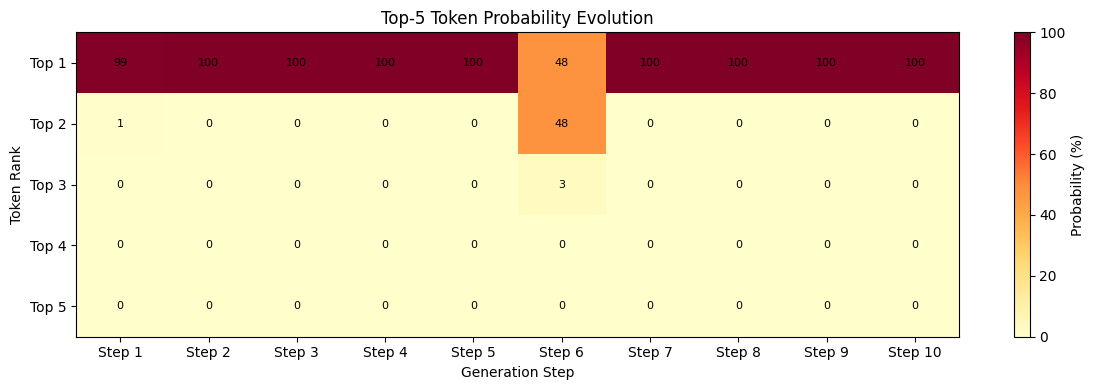

In [75]:
# Create probability matrix for heatmap
num_steps = len(steps)
num_tokens = 5

# Collect data
prob_matrix = np.zeros((num_tokens, num_steps))
token_labels = []

for step_idx, s in enumerate(steps):
    for tok_idx, t in enumerate(s["top_predictions"]):
        prob_matrix[tok_idx, step_idx] = t["prob"] * 100
    if step_idx == 0:
        token_labels = [f"Top {i+1}" for i in range(num_tokens)]

# Plot heatmap
fig, ax = plt.subplots(figsize=(12, 4))
im = ax.imshow(prob_matrix, aspect="auto", cmap="YlOrRd")

ax.set_xticks(range(num_steps))
ax.set_xticklabels([f"Step {i+1}" for i in range(num_steps)])
ax.set_yticks(range(num_tokens))
ax.set_yticklabels(token_labels)
ax.set_xlabel("Generation Step")
ax.set_ylabel("Token Rank")
ax.set_title("Top-5 Token Probability Evolution")

# Add colorbar
cbar = plt.colorbar(im, ax=ax)
cbar.set_label("Probability (%)")

# Add text annotations
for i in range(num_tokens):
    for j in range(num_steps):
        text = ax.text(j, i, f"{prob_matrix[i, j]:.0f}",
                       ha="center", va="center", color="black", fontsize=8)

plt.tight_layout()
plt.show()

## Try Your Own Prompt

In [76]:
# Change this to explore different prompts
MY_PROMPT = "Чий Крим?"

# Quick visualization
logits = get_first_token_logits(MY_PROMPT)
top_k = get_top_k(logits, k=10)

print(f"Prompt: \"{MY_PROMPT}\"\n")
print(f"{'Rank':<6} {'Token':<20} {'Prob':<10}")
print("-" * 40)
for i, t in enumerate(top_k, 1):
    print(f"{i:<6} {repr(t['token']):<20} {t['prob']*100:.2f}%")

Prompt: "Чий Крим?"

Rank   Token                Prob      
----------------------------------------
1      ' �'                 8.15%
2      ' '                  8.15%
3      ' ('                 7.18%
4      ' К'                 6.35%
5      ' Н'                 3.86%
6      ' А'                 3.61%
7      ' В'                 3.20%
8      ' –'                 3.20%
9      ' М'                 2.65%
10     ' С'                 2.65%
